In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from statsmodels.tsa.seasonal import STL


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2019-2024-us-stock-market-data/Stock Market Dataset.csv


# Step 1. Data Import & EDA

## Data Loading & Initial Data Cleansing

In [2]:
df = pd.read_csv("/kaggle/input/2019-2024-us-stock-market-data/Stock Market Dataset.csv")

In [3]:
df.head(5)

,Unnamed: 0,Date,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
0,0,02-02-2024,2.079,NaN,72.28,NaN,3.8215,NaN,"43,194.70",42650.0,...,"5,89,498",10580.0,564.64,4030000.0,171.81,117220000.0,474.99,84710000.0,"2,053.70",NaN
1,1,01-02-2024,2.050,161340.0,73.82,577940.0,3.8535,NaN,"43,081.40",47690.0,...,"5,81,600",9780.0,567.51,3150000.0,159.28,66360000.0,394.78,25140000.0,"2,071.10",260920.0
2,2,31-01-2024,2.100,142860.0,75.85,344490.0,3.9060,NaN,"42,580.50",56480.0,...,"5,78,020",9720.0,564.11,4830000.0,155.20,49690000.0,390.14,20010000.0,"2,067.40",238370.0
3,3,30-01-2024,2.077,139750.0,77.82,347240.0,3.9110,NaN,"42,946.20",55130.0,...,"5,84,680",9750.0,562.85,6120000.0,159.00,42290000.0,400.06,18610000.0,"2,050.90",214590.0
4,4,29-01-2024,2.490,3590.0,76.78,331930.0,3.8790,NaN,"43,299.80",45230.0,...,"5,78,800",13850.0,575.79,6880000.0,161.26,42840000.0,401.02,17790000.0,"2,034.90",1780.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1243 non-null   int64  
 1   Date               1243 non-null   object 
 2   Natural_Gas_Price  1243 non-null   float64
 3   Natural_Gas_Vol.   1239 non-null   float64
 4   Crude_oil_Price    1243 non-null   float64
 5   Crude_oil_Vol.     1220 non-null   float64
 6   Copper_Price       1243 non-null   float64
 7   Copper_Vol.        1206 non-null   float64
 8   Bitcoin_Price      1243 non-null   object 
 9   Bitcoin_Vol.       1243 non-null   float64
 10  Platinum_Price     1243 non-null   object 
 11  Platinum_Vol.      636 non-null    float64
 12  Ethereum_Price     1243 non-null   object 
 13  Ethereum_Vol.      1243 non-null   float64
 14  S&P_500_Price      1243 non-null   object 
 15  Nasdaq_100_Price   1243 non-null   object 
 16  Nasdaq_100_Vol.    1242 

### Check the formatting of those non-numeric columns

In [5]:
df[['Date', 'Bitcoin_Price', 'Platinum_Price', 'Ethereum_Price', 'S&P_500_Price', 'Nasdaq_100_Price', 'Berkshire_Price', 'Gold_Price']].head(5)

,Date,Bitcoin_Price,Platinum_Price,Ethereum_Price,S&P_500_Price,Nasdaq_100_Price,Berkshire_Price,Gold_Price
0,02-02-2024,"43,194.70",901.6,"2,309.28","4,958.61","17,642.73","5,89,498","2,053.70"
1,01-02-2024,"43,081.40",922.3,"2,304.28","4,906.19","17,344.71","5,81,600","2,071.10"
2,31-01-2024,"42,580.50",932.6,"2,283.14","4,848.87","17,137.24","5,78,020","2,067.40"
3,30-01-2024,"42,946.20",931.7,"2,343.11","4,924.97","17,476.71","5,84,680","2,050.90"
4,29-01-2024,"43,299.80",938.3,"2,317.79","4,927.93","17,596.27","5,78,800","2,034.90"


In [6]:
for col in ['Bitcoin_Price', 'Platinum_Price', 'Ethereum_Price', 'S&P_500_Price', 'Nasdaq_100_Price', 'Berkshire_Price', 'Gold_Price']:
    
    df[col] = df[col].str.replace(',','')
    
df = df.astype({'Bitcoin_Price': 'float64', 'Platinum_Price': 'float64', 'Ethereum_Price': 'float64', 
                'S&P_500_Price': 'float64', 'Nasdaq_100_Price': 'float64', 'Berkshire_Price': 'float64', 'Gold_Price': 'float64'})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1243 non-null   int64  
 1   Date               1243 non-null   object 
 2   Natural_Gas_Price  1243 non-null   float64
 3   Natural_Gas_Vol.   1239 non-null   float64
 4   Crude_oil_Price    1243 non-null   float64
 5   Crude_oil_Vol.     1220 non-null   float64
 6   Copper_Price       1243 non-null   float64
 7   Copper_Vol.        1206 non-null   float64
 8   Bitcoin_Price      1243 non-null   float64
 9   Bitcoin_Vol.       1243 non-null   float64
 10  Platinum_Price     1243 non-null   float64
 11  Platinum_Vol.      636 non-null    float64
 12  Ethereum_Price     1243 non-null   float64
 13  Ethereum_Vol.      1243 non-null   float64
 14  S&P_500_Price      1243 non-null   float64
 15  Nasdaq_100_Price   1243 non-null   float64
 16  Nasdaq_100_Vol.    1242 

## Data Grouping

In [8]:
df.columns

Index(['Unnamed: 0', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')

In [9]:
_commodity_price = ['Natural_Gas_Price', 'Crude_oil_Price', 'Copper_Price', 'Platinum_Price', 'Silver_Price', 'Gold_Price']
_commodity_vol   = ['Natural_Gas_Vol.', 'Crude_oil_Vol.', 'Copper_Vol.', 'Platinum_Vol.', 'Silver_Vol.', 'Gold_Vol.']
_crypto_price    = ['Bitcoin_Price', 'Ethereum_Price']
_crypto_vol      = ['Bitcoin_Vol.', 'Ethereum_Vol.']
_index_price     = ['S&P_500_Price', 'Nasdaq_100_Price', 'Berkshire_Price']
_index_vol       = ['Nasdaq_100_Vol.', 'Berkshire_Vol.']
_techs_price     = ['Apple_Price', 'Tesla_Price', 'Microsoft_Price', 'Google_Price', 'Nvidia_Price', 'Netflix_Price', 'Amazon_Price', 'Meta_Price']
_techs_vol       = ['Apple_Vol.', 'Tesla_Vol.', 'Microsoft_Vol.', 'Google_Vol.', 'Nvidia_Vol.', 'Netflix_Vol.', 'Amazon_Vol.', 'Meta_Vol.']

### `Date`

In [10]:
df["Date"] = pd.to_datetime(df["Date"], format='%d-%m-%Y')

In [11]:
df = df.set_index("Date")\
    .drop(columns=df.columns[0])\
    .sort_index()

### `Commodity`

In [12]:
df[_commodity_price].describe(include = 'all')

,Natural_Gas_Price,Crude_oil_Price,Copper_Price,Platinum_Price,Silver_Price,Gold_Price
count,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000,1243.000000
mean,3.494714,67.577064,3.541957,959.003620,21.588977,1759.246742
std,1.822540,20.465500,0.702819,108.012849,3.859288,203.258901
min,1.482000,-37.630000,2.100500,595.200000,11.772000,1272.000000
25%,2.347500,55.095000,2.858750,889.775000,17.998500,1669.600000
50%,2.702000,69.230000,3.666000,944.700000,22.758000,1804.200000
75%,4.055500,80.455000,4.137250,1020.400000,24.512000,1912.800000
max,9.647000,123.700000,4.937500,1297.100000,29.418000,2089.700000


In [13]:
fig = px.line(df, y=_commodity_price, title='Commodity Price Time Series', width = 1000, height = 400)

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [14]:
df[_commodity_vol].describe(include = 'all')

,Natural_Gas_Vol.,Crude_oil_Vol.,Copper_Vol.,Platinum_Vol.,Silver_Vol.,Gold_Vol.
count,1239.000000,1.220000e+03,1206.000000,636.000000,1196.000000,1241.000000
mean,131624.116223,3.989038e+05,35406.616915,9082.515723,67695.418060,211127.671233
std,64385.141749,2.161619e+05,38415.448731,8876.538587,38078.851679,115006.351292
min,1200.000000,1.702000e+04,10.000000,0.000000,0.000000,0.000000
25%,91900.000000,2.835975e+05,370.000000,1120.000000,48150.000000,152200.000000
50%,127370.000000,3.668850e+05,10180.000000,6070.000000,62940.000000,197970.000000
75%,169460.000000,5.072425e+05,68340.000000,15287.500000,79100.000000,257920.000000
max,381970.000000,1.770000e+06,176040.000000,42830.000000,355280.000000,813410.000000


In [15]:
fig = px.line(df, y=_commodity_vol, title='Commodity Vol. Time Series', width = 1000, height = 400)

fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=3, label="3m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

In [16]:
df_platinum_subset = (df.index >= '2020-08-01') & (df.index <= '2023-12-01')

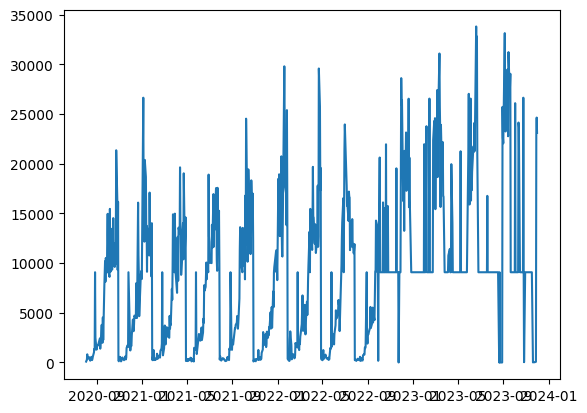

In [17]:
plt.plot(df[df_platinum_subset]["Platinum_Vol."].fillna(df["Platinum_Vol."].mean()))

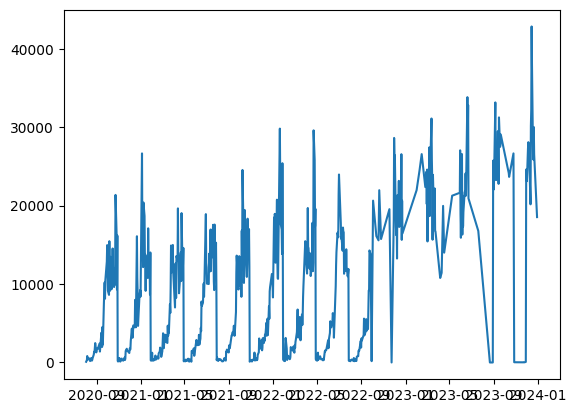

In [18]:
plt.plot(df["Platinum_Vol."].interpolate(method = 'polynomial', order = 1))

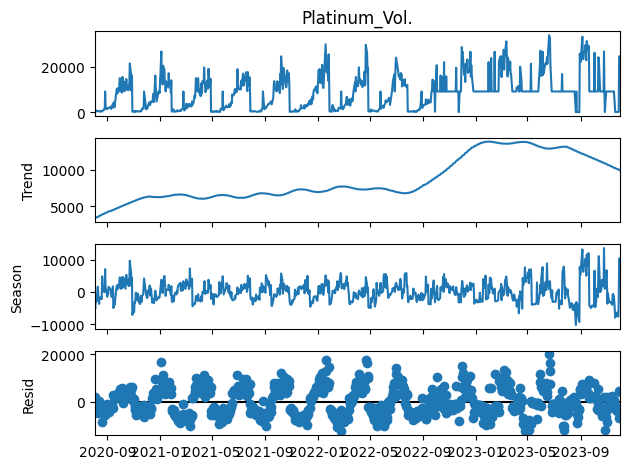

In [19]:
stl_object = STL(df[df_platinum_subset]["Platinum_Vol."].fillna(df["Platinum_Vol."].mean()), period = 91).fit()
stl_object.plot()
plt.show()